In [ ]:
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import os
from tensorflow.keras.applications import VGG16
import keras
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

# DataSet

In [2]:
path = kagglehub.dataset_download("imsparsh/flowers-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-dataset


# Pre-Processing

In [3]:
## پیش پردازش

# مسیر های دیتاست
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

# تنظیم سید برای تکرار پذیری و در نتیجه مقایسه بهتر مقادیر
np.random.seed(42) # تنظیم سید برای نامپای
tf.random.set_seed(42) # تنظیم سید برای تنسورفلو

# ژنراتور مربوط به تصاویر ترِین همراه با آگمنتیشن اولیه
train_datagen = ImageDataGenerator(
    rescale=1./255, # نرمالایز
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2, # بیست درصد برای داده تست
)

# ژنراتور مربوط به تصاویر ولیدیشن برای اینکه آگمنتیشن روی داده های ولیدیشن اعمال نشه
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

# لود و تقسیم داده های ترِین
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224), # ریسایز
    batch_size=32, # اندازه بچ برای آموزش
    class_mode='categorical', # لیبل ها به صورت وان هات
    subset='training', # دریافت فقط بخش آموزشی
    seed=42 # شافل یکسان
)

# لود و تقسیم داده های تست
validation_generator = validation_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # دریافت فقط بخش ولیدیشن
    seed=42
)

# دیدن ایندکس مربوط به هر کلاس
print(train_generator.class_indices)


## بررسی توضیع کلاس ها

# بررسی تعداد نمونه های هر کلاس
class_counts = np.bincount(train_generator.classes)
print("Class distribution:", class_counts)

# برقرار کردن تعادل بین کلاس ها
class_weights = compute_class_weight(
    'balanced', # روش انجام تعادل
    classes=np.arange(len(class_counts)),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


## لود کردن دیتاست مربوط به تست عملکرد که توی این دیتاست وجود داره

# خوندن فایلی که توش اسم تصاویر قرار داره
test_csv = pd.read_csv(os.path.join(path, 'Testing_set_flower.csv'))
test_image_names = test_csv.iloc[:, 0].values

# متغیر برای ذخیره تصاویر تست
test_images = []

# نوشتن تصاویر توی متغیر
for img_name in test_image_names:
    img_path = os.path.join(test_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_norm = img_array / 255.0
    test_images.append(img_norm)

test_images = np.array(test_images)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Class distribution: [401 517 398 396 486]
Class weights: {0: np.float64(1.0962593516209476), 1: np.float64(0.8502901353965183), 2: np.float64(1.1045226130653267), 3: np.float64(1.11010101010101), 4: np.float64(0.9045267489711935)}


# Transfer Learning: Feature Extraction

In [4]:
# لود مدل وی جی جی 16 بدون لایه های دِنس
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# فریز کردن
base_model.trainable = False

# اضافه کردن لایه های دِنس
model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=5, activation='softmax'))

# کامپایل کردن مدل
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,204,549 (80.89 MB)

 Trainable params: 6,489,861 (24.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Model Training

In [5]:
# فیت کردن مدل

lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size + 1,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping],
)

# ارزیابی مدل
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# ذخیره مدل
model.save('flower_classifier.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 78s 890ms/step - accuracy: 0.4506 - loss: 2.2820 - val_accuracy: 0.7372 - val_loss: 1.1471 - learning_rate: 0.0010
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 494ms/step - accuracy: 0.7570 - loss: 1.1018 - val_accuracy: 0.7828 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 36s 523ms/step - accuracy: 0.8210 - loss: 0.8615 - val_accuracy: 0.7920 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 506ms/step - accuracy: 0.8325 - loss: 0.7590 - val_accuracy: 0.7719 - val_loss: 0.9241 - learning_rate: 0.0010
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - accuracy: 0.8539 - loss: 0.7084 - val_accuracy: 0.7755 - val_loss: 0.8902 - learning_rate: 0.0010
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 36s 523ms/step - accuracy: 0.8885 - loss: 0.5997 - val_accuracy: 0.8248 - val_loss: 0.7660 - learning_rate: 5.0000e-04
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 496ms/step - accuracy: 0.9165 - loss

Validation Loss: 0.7611, Validation Accuracy: 0.8285


# Model Performance

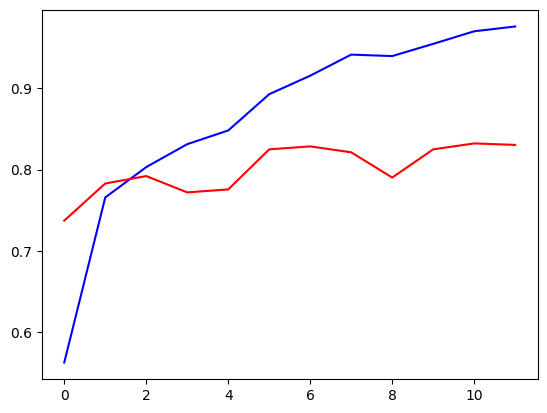

In [6]:
# نمایش عملکرد مدل روی اکیورسی

plt.plot(history.history['accuracy'], color='blue') # داده ترین
plt.plot(history.history['val_accuracy'], color='red') # داده تست

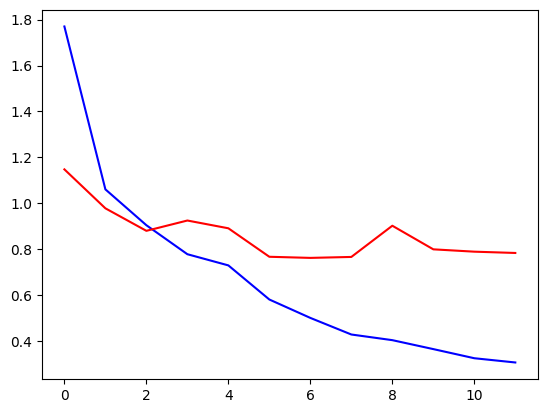

In [7]:
# نمایش عملکرد مدل روی تابع هزینه

plt.plot(history.history['loss'], color='blue') # داده ترین
plt.plot(history.history['val_loss'], color='red') # داده تست

# Transfer Learning: Fine-Tuning

In [8]:
# فاین تیون کردن مدل روی دیتاست

model = keras.models.load_model('flower_classifier.h5')

# انتخاب لایه وی جی جی 16
base_model = model.layers[0]

# آنفریز کردن لایه های آخر که میشه بلاک 5
for layer in base_model.layers[-4:]: # چهار لایه آخر
    layer.trainable = True

# چک کردن وضعیت فریز بودن لایه ها
for layer in base_model.layers:
    print(f'Layer {layer.name} - trainable: {layer.trainable}')

# کامپایل کردن مدل
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# فیت کردن مدل
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size + 1,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
)

# ارزیابی مدل
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# ذخیره مدل
model.save('finetuned_flower_classifier.h5')

Layer input_layer - trainable: True
Layer block1_conv1 - trainable: False
Layer block1_conv2 - trainable: False
Layer block1_pool - trainable: False
Layer block2_conv1 - trainable: False
Layer block2_conv2 - trainable: False
Layer block2_pool - trainable: False
Layer block3_conv1 - trainable: False
Layer block3_conv2 - trainable: False
Layer block3_conv3 - trainable: False
Layer block3_pool - trainable: False
Layer block4_conv1 - trainable: False
Layer block4_conv2 - trainable: False
Layer block4_conv3 - trainable: False
Layer block4_pool - trainable: False
Layer block5_conv1 - trainable: True
Layer block5_conv2 - trainable: True
Layer block5_conv3 - trainable: True
Layer block5_pool - trainable: True
Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 577ms/step - accuracy: 0.8464 - loss: 0.7501 - val_accuracy: 0.8540 - val_loss: 0.5819
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 502ms/step - accuracy: 0.9276 - loss: 0.4067 - val_accuracy: 0.8631 - val_loss: 0.6734
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━

Validation Loss: 0.5819, Validation Accuracy: 0.8540


# Model Performance

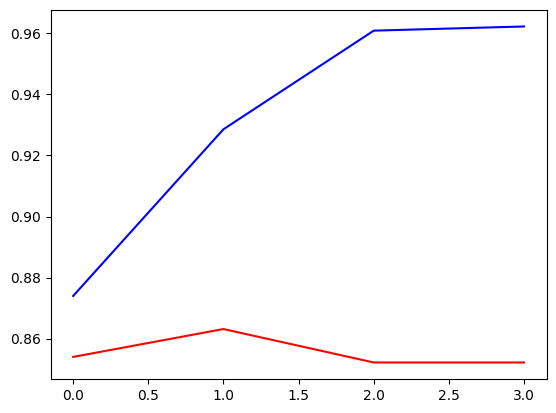

In [9]:
# نمایش عملکرد مدل روی اکیورسی

plt.plot(history_finetune.history['accuracy'], color='blue') # داده ترین
plt.plot(history_finetune.history['val_accuracy'], color='red') # داده تست

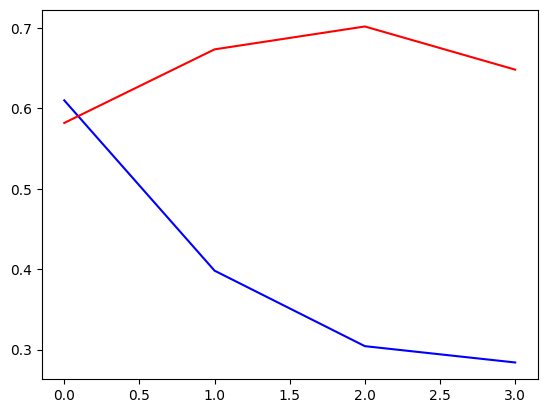

In [10]:
# نمایش عملکرد مدل روی تابع هزینه

plt.plot(history_finetune.history['loss'], color='blue') # داده ترین
plt.plot(history_finetune.history['val_loss'], color='red') # داده تست

# Testing

In [11]:
# تست مدل روی یکی از داده های تست

model = keras.models.load_model('flower_classifier.h5')

predictions = model.predict(test_images, batch_size=32)

# ایندکس بیشترین عدد هر پریدیکشن
predicted_classes = np.argmax(predictions, axis=1)

# جایگزین کردن اعداد با اسم کلاس ها
classes_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
predicted_classes_names = [classes_names[i] for i in predicted_classes]

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step


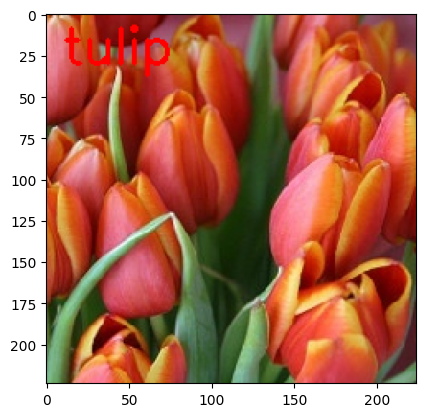

In [12]:
# نمایش یک تصویر با کلاسش

idx = 154

image = test_images[idx]
image = image.reshape(224, 224, 3)
image = cv2.putText(image.copy(), predicted_classes_names[idx], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
plt.imshow(image)